In [0]:
import os
import re
import json

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import pytz
from datetime import datetime, timedelta

import pyspark.sql.functions as spf

# ------------------------------------------------------------------------------
# setup spark configurations
adls_name = dbutils.secrets.get(scope="storage-secret-scope", key="storage-account-name")
spark.conf.set(f"fs.azure.account.auth.type.{adls_name}.dfs.core.windows.net", "OAuth")
spark.conf.set(f"fs.azure.account.oauth.provider.type.{adls_name}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")

client_id = dbutils.secrets.get(scope="ams-dataplatform-config-scope", key="ams-aad-sp-client-id")
spark.conf.set(f"fs.azure.account.oauth2.client.id.{adls_name}.dfs.core.windows.net",  client_id)

client_secret = dbutils.secrets.get(scope="ams-dataplatform-config-scope", key="ams-aad-sp-client-secret")
spark.conf.set(f"fs.azure.account.oauth2.client.secret.{adls_name}.dfs.core.windows.net", client_secret)

tenant_id = dbutils.secrets.get(scope="ams-dataplatform-config-scope", key="ams-aad-sp-tenant-id")
client_endpoint = f"https://login.microsoftonline.com/{tenant_id}/oauth2/token"
spark.conf.set(f"fs.azure.account.oauth2.client.endpoint.{adls_name}.dfs.core.windows.net", client_endpoint)

spark.conf.set("spark.sql.legacy.parquet.datetimeRebaseModeInWrite", "LEGACY")
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# ------------------------------------------------------------------------------
# get execution parameters
dbutils.widgets.text("stacking_config_path", "")
dbutils.widgets.text("debug_flag", "1")
dbutils.widgets.text("fecha_inicio_apilado", "")
dbutils.widgets.text("fecha_fin_apilado", "")


In [0]:
from src.dbutils.config import DBFSConfigHandler

# ------------------------------------------------------------------------------
# load databricks config
config_path = dbutils.widgets.get("stacking_config_path")
config_path = f'abfss://test@{adls_name}.dfs.core.windows.net/{config_path}'
config = DBFSConfigHandler(dbutils)(config_path)


## 1. Datasets

### 1.1. Dumps Dataset
En primer lugar, se llevará a cabo la importación de la dataset `dataset_dumps` que contiene el registro de las últimas decargas de mineral realizadas en la planta de chancado. Esta tabla será importada como un `pandas DataFrame` bajo la variable `df_dumps`.

In [0]:
# ------------------------------------------------------------------------------
# get dumps dataset
dataset = config.get(('datasets', 'dumps'))

# get dataset path
dataset_ctnr = dataset['storage']['container']
dataset_path = dataset['storage']['path']

# get dataset as pandas dataframe
dataset_path = os.path.join(dataset_ctnr, dataset_path)
df_dumps = pd.read_pickle(dataset_path)

df_dumps.set_index(keys='caex_id', inplace=True)
df_dumps.head()


,dump_timestamp,truck_id,dump_tons,dump_id,dump_easting,dump_northing,blast_id,fase,load_easting,load_northing,load_elevation,bucket_easting,bucket_northing,bucket_elevation,ugm,cut,cus,co3,no3,acido,szo,rsw,cao,pgl,chl,ser,qz,feo,cal,yes,D00,D01,D02,D03,D04,D05,D06,D07,D08,D09,...,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58
caex_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2025-09-03 07:59:36,C30,295.0,CHAN-TOLV2,410865.65625,7497789.5,F06_1528_260,FASE 6,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.244289,0.101158,1.387273,0.105220,11.244106,0.434469,0.013400,4.5391,NaN,4.1193,23.624901,NaN,NaN,NaN,NaN,0.147404,0.008611,0.009065,0.009536,0.010024,0.010529,0.011051,0.01159,0.012143,0.01271,...,0.018738,0.01931,0.019858,0.020378,0.020865,0.02131,0.021709,0.022055,0.02234,0.022559,0.022705,0.02277,0.022751,0.02264,0.022435,0.02213,0.021725,0.021218,0.020611,0.019904,0.019103,0.018214,0.017245,0.016206,0.015109,0.013968,0.012797,0.011612,0.01043,0.009267,0.008139,0.007061,0.006046,0.005105,0.004247,0.003477,0.0028,0.002214,0.001718,0.003152
1,2025-09-03 08:04:01,C104,295.0,CHAN-TOLV1,410856.62500,7497769.0,F05_1368_190,FASE 5,NaN,NaN,NaN,NaN,NaN,NaN,40.0,0.231954,0.161369,0.335726,0.100000,3.749751,0.624971,0.704700,4.9819,NaN,6.5186,19.797300,NaN,NaN,NaN,NaN,0.147404,0.008611,0.009065,0.009536,0.010024,0.010529,0.011051,0.01159,0.012143,0.01271,...,0.018738,0.01931,0.019858,0.020378,0.020865,0.02131,0.021709,0.022055,0.02234,0.022559,0.022705,0.02277,0.022751,0.02264,0.022435,0.02213,0.021725,0.021218,0.020611,0.019904,0.019103,0.018214,0.017245,0.016206,0.015109,0.013968,0.012797,0.011612,0.01043,0.009267,0.008139,0.007061,0.006046,0.005105,0.004247,0.003477,0.0028,0.002214,0.001718,0.003152
2,2025-09-03 08:12:04,C28,295.0,CHAN-TOLV2,410865.65625,7497789.5,F05_1368_190,FASE 5,NaN,NaN,NaN,NaN,NaN,NaN,30.0,0.242233,0.179049,1.402887,0.100000,11.327331,1.223859,0.506600,4.9665,NaN,6.5551,20.145700,NaN,NaN,NaN,NaN,0.147404,0.008611,0.009065,0.009536,0.010024,0.010529,0.011051,0.01159,0.012143,0.01271,...,0.018738,0.01931,0.019858,0.020378,0.020865,0.02131,0.021709,0.022055,0.02234,0.022559,0.022705,0.02277,0.022751,0.02264,0.022435,0.02213,0.021725,0.021218,0.020611,0.019904,0.019103,0.018214,0.017245,0.016206,0.015109,0.013968,0.012797,0.011612,0.01043,0.009267,0.008139,0.007061,0.006046,0.005105,0.004247,0.003477,0.0028,0.002214,0.001718,0.003152
3,2025-09-03 08:45:19,C26,295.0,CHAN-TOLV2,410865.65625,7497789.5,F05_1352_191,FASE 5,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.563745,0.443349,0.563263,0.100000,9.495300,1.542519,0.221400,5.1780,NaN,5.9853,20.741199,NaN,NaN,NaN,NaN,0.147404,0.008611,0.009065,0.009536,0.010024,0.010529,0.011051,0.01159,0.012143,0.01271,...,0.018738,0.01931,0.019858,0.020378,0.020865,0.02131,0.021709,0.022055,0.02234,0.022559,0.022705,0.02277,0.022751,0.02264,0.022435,0.02213,0.021725,0.021218,0.020611,0.019904,0.019103,0.018214,0.017245,0.016206,0.015109,0.013968,0.012797,0.011612,0.01043,0.009267,0.008139,0.007061,0.006046,0.005105,0.004247,0.003477,0.0028,0.002214,0.001718,0.003152
4,2025-09-03 08:48:11,C28,295.0,CHAN-TOLV2,410865.65625,7497789.5,F05_1368_190,FASE 5,NaN,NaN,NaN,NaN,NaN,NaN,30.0,0.154548,0.109555,1.208725,0.093168,8.873387,0.383545,0.461506,4.7687,NaN,6.5145,19.776300,NaN,NaN,NaN,NaN,0.147404,0.008611,0.009065,0.009536,0.010024,0.010529,0.011051,0.01159,0.012143,0.01271,...,0.018738,0.01931,0.019858,0.020378,0.020865,0.02131,0.021709,0.022055,0.02234,0.022559,0.022705,0.02277,0.022751,0.02264,0.022435,0.02213,0.021725,0.021218,0.020611,0.019904,0.019103,0.018214,0.017245,0.016206,0.015109,0.013968,0.012797,0.011612,0.01043,0.009267,0.008139,0.007061,0.006046,0.005105,0.004247,0.003477,0.0028,0.002214,0.001718,0.003152


### 1.2. Sensors Dataset
Por otro lado, se llevará a cabo la importación del dataset `dataset_sensors` que contiene el registro con las mediciones de las últimas horas de la instrumentación instalada en la planta de chancado. Esta tabla será importada como un `pandas DataFrame` bajo la variable `df_sensors`.

In [0]:
# ------------------------------------------------------------------------------
# get sensors dataset
dataset = config.get(('datasets', 'sensors'))

# get dataset path
dataset_ctnr = dataset['storage']['container']
dataset_path = dataset['storage']['path']

# get dataset as pandas dataframe
dataset_path = os.path.join(dataset_ctnr, dataset_path)
df_sensors = pd.read_pickle(dataset_path)

df_sensors.set_index(keys='timestamp', inplace=True)
df_sensors = df_sensors[df_sensors['flag']]
df_sensors.head()


,nivel_tolva_primario_1,nivel_tolva_primario_2,nivel_tolva_secundario_1,nivel_tolva_secundario_2,nivel_tolva_secundario_3,nivel_tolva_terciario_1,nivel_tolva_terciario_2,nivel_tolva_terciario_3,nivel_tolva_terciario_4,nivel_tolva_terciario_5,nivel_tolva_terciario_6,nivel_tolva_terciario_7,nivel_tolva_terciario_8,nivel_tolva_terciario_9,nivel_tolva_terciario_10,nivel_tolva_terciario_11,nivel_tolva_terciario_12,nivel_tolva_aglomerado_1,nivel_tolva_aglomerado_2,corriente_correa_1,corriente_correa_2,corriente_correa_3_1,corriente_correa_3_2,corriente_correa_4,corriente_correa_5_1,corriente_correa_5_2,corriente_correa_6,corriente_correa_7_1,corriente_correa_7_2,corriente_correa_10_1,corriente_correa_10_2,corriente_correa_11,corriente_correa_12_1,corriente_correa_12_2,corriente_correa_13_1,corriente_correa_13_2,corriente_correa_14,velocidad_feeder_primario_1,velocidad_feeder_primario_2,velocidad_feeder_secundario_1,...,css_chancador_secundario_2,css_chancador_secundario_3,css_chancador_terciario_1,css_chancador_terciario_2,css_chancador_terciario_3,css_chancador_terciario_4,css_chancador_terciario_5,css_chancador_terciario_6,css_chancador_terciario_7,css_chancador_terciario_8,css_chancador_terciario_9,css_chancador_terciario_10,css_chancador_terciario_11,css_chancador_terciario_12,posicion_tripper_secundario_1,posicion_tripper_secundario_2,posicion_tripper_secundario_3,posicion_tripper_terciario_1,posicion_tripper_terciario_2,posicion_tripper_terciario_3,posicion_tripper_terciario_4,posicion_tripper_terciario_5,posicion_tripper_terciario_6,posicion_tripper_terciario_7,posicion_tripper_terciario_8,posicion_tripper_terciario_9,posicion_tripper_terciario_10,posicion_tripper_terciario_11,posicion_tripper_terciario_12,flujo_agua_aglomerado_1,flujo_agua_aglomerado_2,flujo_acido_aglomerado_1,flujo_acido_aglomerado_2,gps_stacker_interior_x,gps_stacker_interior_y,gps_stacker_interior_z,gps_stacker_exterior_x,gps_stacker_exterior_y,gps_stacker_exterior_z,flag
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-09-03 07:59:00,45.492920,61.986540,78.166430,45.425484,28.694364,61.256794,42.012450,0.007515,0.007529,0.007519,0.007515,1.090453,0.007519,0.007519,3.700022,0.007515,NaN,75.919914,67.586754,0.0,106.313950,67.0,70.0,87.86044,53.0,51.771774,0.0,0.0,0.0,74.585700,79.0,128.868200,31.417057,31.562020,12.754180,15.441958,30.733168,NaN,99.305650,0.0,...,18.684887,22.210491,0.0,144.883652,21.732185,58.502773,39.688572,68.657910,37.924484,125.534836,60.055424,106.368729,66.987770,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,120.511864,0.0,0.0,9405.590,4262.44873,1642.03650,9406.099,4591.91357,1651.74011,True
2025-09-03 07:59:30,45.485767,103.499900,78.013145,45.144108,23.611788,61.257040,42.011818,0.007515,0.007529,0.007519,0.007515,1.090679,0.007519,0.007519,3.700741,0.007515,NaN,75.971040,67.314575,0.0,104.286812,68.0,70.0,86.16399,53.0,51.145920,0.0,0.0,0.0,74.086680,79.0,131.989822,31.835407,31.589344,12.712484,15.381061,29.787735,NaN,99.219986,0.0,...,18.644625,22.204456,0.0,144.883667,21.732994,58.503624,39.688460,68.661026,37.926880,125.534882,60.055600,106.368851,66.987810,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,120.524666,0.0,0.0,9406.056,4262.44775,1642.02551,9406.555,4591.90900,1651.74792,True
2025-09-03 08:00:00,45.478615,101.327827,78.069664,36.478775,28.514572,61.257282,42.011180,0.007515,0.007529,0.007519,0.007515,1.090905,0.007519,0.007519,3.707954,0.007515,NaN,76.196510,67.369000,0.0,103.849190,68.0,70.0,85.16399,53.0,51.914963,0.0,0.0,0.0,72.340380,79.0,130.082382,32.275276,31.980070,12.919944,15.041453,29.858248,NaN,99.018030,0.0,...,18.604364,22.198421,0.0,144.883700,21.733803,58.504475,39.688347,68.664140,37.929276,125.534920,60.055780,106.368965,66.987854,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,120.091515,0.0,0.0,9406.056,4262.44336,1642.03394,9406.556,4591.90527,1651.73413,True
2025-09-0

### 1.3. Granulometry Dataset

Por otro lado, para poder acceder con mayor facilidad a la información granulométrica de los registros de mineral, en el siguiente bloque de código se obtiene la serie de columnas que definen los intervalos granulométricos a procesar.

In [0]:
# ------------------------------------------------------------------------------
# get granulometry dataset
dataset = config.get(('datasets', 'granulometry'))

# get dataset path
dataset_ctnr = dataset['storage']['container']
dataset_path = dataset['storage']['path']

# get dataset as pandas dataframe
dataset_path = os.path.join(dataset_ctnr, dataset_path)
df_grmty = pd.read_pickle(dataset_path)
df_grmty = df_grmty.set_index(keys='blast_id')

# ------------------------------------------------------------------------------
# get granulometry parameters
params = dataset['parameters']
alpha = np.power(2, params['beta'])

# get granulometry bins
xmin = params['p80']*np.power(alpha, params['nmin'])
xmax = params['p80']*np.power(alpha, params['nmax'])
num_bins = params['nmax'] - params['nmin'] + 1

grmty_keys = ['D{:02d}'.format(i) for i in range(num_bins)]
grmty_bins = np.geomspace(xmin, xmax, num_bins)
grmty_bins = pd.Series(grmty_bins, index=grmty_keys)


## 2. Model Building

### 2.1. Stacking Manager
Antes de configurar los bloques que modelarán los distintos equipos de proceso involucrados en esta etapa, se comienza por configurar la instancia `StackerManager`. Esta contiene una serie de utilidades para el procesamiento de los sensores de posición del puente apilador y por tanto resulta de suma utilidad a la hora modelar los equipos de apilado. Para su inicialización es necesario ingresar las posiciones y dimensiones de todos los módulos de lixiviación contenidas en la tabla `df_pads`.

In [0]:
from src.mineflow.utils.stacker_utils import StackerManager

# ------------------------------------------------------------------------------
# get stacker pads pyspark dataframe
dataset = config.get(('datasets', 'pads'))

sp_pads = spark.sql(
    """
    SELECT DISTINCT
        modulos.id_modulo,
        modulos.centroide_x, modulos.centroide_y,
        modulos.x_length, modulos.y_length
    
    FROM
        hive_metastore.ant_cobre_acc_rpt_mineral_tracking.ciclo_de_vida_modulos_lixiviacion AS modulos
    """
    )

# get stacker pads as pandas dataframe
df_pads = sp_pads.toPandas()
df_pads = df_pads.rename(**dataset['rename'])

df_pads.sort_values(by='pad_id', ignore_index=True, inplace=True)
df_pads.set_index(keys='pad_id', inplace=True)

# ------------------------------------------------------------------------------
# get stacker manager
manager = StackerManager(pads=df_pads)
manager.pads['ylength'] = 5.0
manager.pads.head()


,xcentre,ycentre,xlength,ylength
pad_id,,,,
1,9634.25,4062.0,49.5,5.0
2,9584.75,4062.0,49.5,5.0
3,9535.25,4062.0,49.5,5.0
4,9485.75,4062.0,49.5,5.0
5,9436.25,4062.0,49.5,5.0


Aprovechando esta última inicialización, a continuación se obtiene la serie temporal con la posición del puente apilador en cada timestep del periodo de simulación. Utilizando el método `StackerManager.to_pad` es posible filtrar aquellos puntos que se escapan de la tolerancia de los sensores GPS.

In [0]:
# ------------------------------------------------------------------------------
# get stacker sensors
stacker_keys = [val['key'] for _, val in config.get('stacker')['sensors'].items()]

# get stacker x coordinates
gps_keys = [key for key in stacker_keys if key.endswith('x')]
stacker_x = df_sensors[gps_keys].mean(axis=1)

# get stacker y coordinates
gps_keys = [key for key in stacker_keys if key.endswith('y')]
stacker_y = df_sensors[gps_keys].mean(axis=1)

# get stacker xy coordinates
stacker_xy = np.vstack([stacker_x, stacker_y]).T
stacker_xy = pd.DataFrame(stacker_xy, columns=['x', 'y'], index=df_sensors.index)

# ------------------------------------------------------------------------------
# get stacker x coordinates
nan_mask = (manager.to_pad(stacker_xy.values) == -1)
stacker_xy[nan_mask] = np.nan


### 2.2. Stacking Belts
En esta sección, se configuran los bloques `ScheduleDelayer` que modelarán el transporte del mineral a través de las correas transportadoras de la planta de lixiviación. Estos bloques simulan numéricamente el tiempo que tarda el mineral en pasar por cada una de las correas a partir de la información proporcionada por sus respectivos sensores de corriente.


In [0]:
from src.mineflow.utils.conveyor_utils import conveyor_residence
from src.mineflow.blocks.flow import ScheduleDelayer

# ------------------------------------------------------------------------------
# get oversize belts
stacker_belts = list()

for blt in config.get('stacking_belts'):

    # get belt speed
    blt_key = blt['sensors']['current']['key']
    print(blt_key)
    blt_speed = df_sensors[blt_key].gt(blt['threshold'])
    
    blt_speed = blt_speed.fillna(0.0)
    blt_speed = blt_speed.mul(blt['speed'])
    
    blt_speed = blt_speed.resample('S').asfreq()
    blt_speed = blt_speed.interpolate(method='nearest')

    # get belt length
    blt_length = blt['length']

    if blt['name'] == '3210_CV012_C02':
        pads_xmax = (df_pads['xcentre'] + df_pads['xlength']/2).max()
        blt_length = 2560 - (pads_xmax - stacker_xy['x'])

        blt_length = blt_length.resample('S').asfreq()
        blt_length = blt_length.interpolate(method='nearest')

    # ----------------------------------------------------------------------
    # get belt schedule
    blt_default = blt['speed']
    blt_schedule = conveyor_residence(blt_speed, blt_length, blt_default)

    # get belt block
    block = ScheduleDelayer(schedule=blt_schedule)
    stacker_belts.append(block)
    

corriente_correa_12_1
corriente_correa_13_1
corriente_correa_14


### 2.2. Stacker
En esta sección se configura el bloque `ScheduleDivider` que modelará la distribución del mineral en los módulos de la planta de lixiviación. A partir de las posiciones GPS del puente apilador y la distribución espacial de los módulos, es posible determinar, para cada timestep, el módulo y franja de destino del mineral que es procesado por el stacker.


#### 2.2.1. Stacking Pads

En primer lugar, es necesario determinar los módulos de lixiviación que son alimentados por el puente apilador durante la simulación. Para esto, en el siguiente bloque de código se obtienen todos los ciclos de apilado involucrados en la simulación. Notar que este procesamiento introduce un margen respecto a la ventana de tiempo de la simulación para minimizar errores en la detección de franjas de apilado.

In [0]:
from src.utils.dataset import set_schema

# ------------------------------------------------------------------------------
# get dataset timestamps
dataset_start = df_sensors.index.min() - timedelta(days=30)
dataset_end = df_sensors.index.max() + timedelta(days=30)

# get pads dataset as pyspark dataframe
dataset = config.get(('datasets', 'pads'))

sp_pads = spark.sql(
    """
    SELECT
        modulos.id_modulo, modulos.id_ciclo, 
        modulos.inicio_apilamiento, modulos.fin_apilamiento
    
    FROM
        hive_metastore.ant_cobre_acc_rpt_mineral_tracking.ciclo_de_vida_modulos_lixiviacion AS modulos
        INNER JOIN (
            SELECT
                id_modulo, MAX(id_ciclo) AS ciclo_actual
            FROM
                hive_metastore.ant_cobre_acc_rpt_mineral_tracking.ciclo_de_vida_modulos_lixiviacion
            WHERE
                inicio_apilamiento >= TO_TIMESTAMP("{timestamp_start}")
                AND inicio_apilamiento < TO_TIMESTAMP("{timestamp_end}")  
            GROUP BY id_modulo
            ) AS tmp

        ON modulos.id_modulo = tmp.id_modulo
        AND modulos.id_ciclo = tmp.ciclo_actual
    """.format(
        timestamp_start=dataset_start,
        timestamp_end=dataset_end
        )
    )

# ------------------------------------------------------------------------------
# get dataset as pandas dataframe
df_pads = sp_pads.toPandas()
df_pads = df_pads.rename(**dataset['rename'])

# get dataset dataframe
kwargs = dataset['set_schema']
df_pads = set_schema(df_pads, **kwargs)

kwargs = dict(ignore_index=True)
df_pads = df_pads.sort_values(by='timestamp_start', **kwargs)
df_pads.set_index(keys='pad_id', inplace=True)

# ------------------------------------------------------------------------------
# get pads stacking time
pads_time = (df_pads['timestamp_end'] - df_pads['timestamp_start']).dt.total_seconds()
pads_time = (pads_time/3600)

# get dataset start timestamp
pads_mask = (df_pads['timestamp_end'] < df_sensors.index.min()) & (pads_time > 10)
dataset_start = df_sensors.index.min()
if pads_mask.any():
    dataset_start = df_pads[pads_mask]['timestamp_start'].max()

# get dataset end timestamp
pads_mask = (df_pads['timestamp_start'] > df_sensors.index.max()) & (pads_time > 10)
dataset_end = df_sensors.index.max()
if pads_mask.any():
    dataset_end = df_pads[pads_mask]['timestamp_end'].min()

# ------------------------------------------------------------------------------
# get dataset pads
pads_mask = (df_pads['timestamp_end'] > dataset_start) & (df_pads['timestamp_start'] < dataset_end)
df_pads[pads_mask].head()


,loop_id,timestamp_start,timestamp_end
pad_id,,,
78,12,2025-09-01 08:42:30,2025-09-02 11:10:00
79,12,2025-09-02 11:10:30,2025-09-03 07:59:00
80,12,2025-09-03 07:59:30,2025-09-04 05:21:00
81,12,2025-09-04 05:21:30,2025-09-04 23:23:30
82,12,2025-09-04 23:24:00,2025-09-05 08:12:30


A partir de los ciclos de apilado obtenidos en el bloque anterior es posible obtener la ventana de tiempo a analizar para identificar todas las franjas de apilado que podrían estar involucradas durante la simulación. Así, mediante los timestamps `dataset_start` y `dataset_end` se obtiene la serie temporal del puente apilador a analizar (`df_stacker`).

In [0]:
from src.dbutils.pyspark import rename_columns
from src.utils.dataset import set_schema

# ------------------------------------------------------------------------------
# get stacker sensors as pyspark dataframe
dataset = config.get(('datasets', 'stacker'))

sp_stacker = spark.sql(
    """
        select 
            sensores.id_tag as tag_nombre,
            from_utc_timestamp(sensores.timestamp, 'America/Santiago') as Timestamp,
            sensores.valor as medida_valor
        from ant_raw.pi_system_data AS sensores
        INNER JOIN
            ant_prov_acc_rpt_mineral_tracking.tags_usados_mineral_tracking AS tags 
            ON lower(sensores.id_tag) = lower(tags.tag_nombre)

        WHERE TRUE
        AND sensores.timestamp >= to_utc_timestamp("{timestamp_start}", 'America/Santiago')
        AND sensores.timestamp < to_utc_timestamp("{timestamp_end}", 'America/Santiago')     
    """.format(
        timestamp_start=dataset_start,
        timestamp_end=dataset_end
        )
    )

# ------------------------------------------------------------------------------
# pivot dataset by timestamps
sp_stacker = sp_stacker.groupby("Timestamp").pivot("tag_nombre").agg(spf.first("medida_valor"))
sp_stacker = rename_columns(sp_stacker, **dataset['rename'])

# get dataset as pandas dataframe
query_columns = pd.Series(dataset['rename']['columns'])
sp_stacker = sp_stacker.select([spf.col(col) for col in query_columns])
df_stacker = sp_stacker.toPandas()

# get dataset dataframe
kwargs = dataset['set_schema']
df_stacker = set_schema(df_stacker, **kwargs)

kwargs = dict(ignore_index=True)
df_stacker = df_stacker.sort_values(by='timestamp', **kwargs)

df_stacker.set_index(keys='timestamp', inplace=True)
df_stacker


,gps_stacker_interior_x,gps_stacker_interior_y,gps_stacker_exterior_x,gps_stacker_exterior_y,corriente_correa_14,pesometro_correa_10
timestamp,,,,,,
2025-09-01 08:42:30,9307.436,4262.46800,9307.926,4591.92700,31.568142,6195.44500
2025-09-01 08:43:00,9307.436,4262.45700,9307.926,4591.92773,32.080400,6068.10400
2025-09-01 08:43:30,9307.436,4262.45361,9307.926,4591.93066,31.223202,6106.22559
2025-09-01 08:44:00,9307.436,4262.44600,9307.926,4591.92725,31.419727,6081.70200
2025-09-01 08:44:30,9307.436,4262.44400,9307.926,4591.92700,31.270410,5916.29053
...,...,...,...,...,...,...
2025-09-06 18:10:00,9510.584,4226.54541,9509.529,3896.89160,29.226774,6158.64500
2025-09-06 18:10:30,9510.584,4226.54100,9509.527,3896.89063,28.212097,5660.03100
2025-09-06 18:11:00,9510.585,4226.53500,9509.526,3896.88965,29.227646,5372.92000


#### 2.2.2. Stacking Steps
Para identificar todas las franjas de apilado en la serie temporal de análisis `df_stacker`, a continuación se utiliza el método `StackerManager.find_steps`, el cual procesa las posiciones del puente apilador y compila un `pandas.DataFrame` con toda la información de las franjas detectadas.

In [0]:
# ------------------------------------------------------------------------------
# get stacker sensors
stacker_keys = [val['key'] for _, val in config.get('stacker')['sensors'].items()]

# get stacker x coordinates
gps_keys = [key for key in stacker_keys if key.endswith('x')]
stacker_x = df_stacker[gps_keys].mean(axis=1)

# get stacker y coordinates
gps_keys = [key for key in stacker_keys if key.endswith('y')]
stacker_y = df_stacker[gps_keys].mean(axis=1)

# get stacker xy coordinates
stacker_xy = np.vstack([stacker_x, stacker_y]).T
stacker_xy = pd.DataFrame(stacker_xy, columns=['x', 'y'], index=df_stacker.index)

# ------------------------------------------------------------------------------
# # get stacker pads mask
pads_mask = (manager.to_pad(stacker_xy.values) >= 0)

try:
    # get stacker steps dataframe
    kwargs = dict(axis='x', threshold=10.0, distance=0.25)
    df_steps = manager.find_steps(stacker_xy[pads_mask], **kwargs)
    df_steps.head()

except ValueError:
    dbutils.notebook.exit('')


Por último, para eliminar posibles falsos positivos en la detección de las franjas de apilado, cada franja es analizada y discriminada respecto a las toneladas de mineral acumulado durante su periodo de apilado.

In [0]:
from src.mineflow.utils.timeseries_utils import infer_timestep

# ------------------------------------------------------------------------------
# get steps tons
steps_tons = np.zeros((df_steps.shape[0], ), dtype=np.float64)

for i in df_steps.index:

    # get step timestamps
    tmsp_keys = ['timestamp_start', 'timestamp_end']
    tmsp_start, tmsp_end = df_steps.loc[i, tmsp_keys]
    
    # get step tons
    step_tph = df_stacker.loc[tmsp_start:tmsp_end, 'pesometro_correa_10']
    step_tph = step_tph.fillna(0.0)

    freq = infer_timestep(df_sensors.index)
    steps_tons[i] = step_tph.mul(freq/3600).sum()

# ------------------------------------------------------------------------------
# get stacker steps
drop_mask = (steps_tons < 250)
df_steps = df_steps[~drop_mask].reset_index(drop=True)

# get stacker steps dataframe
for _, df in df_steps.groupby(by='pad_id'):
    step_keys = np.arange(df.shape[0], dtype=np.int32)
    df_steps.loc[df.index, 'step_id'] = step_keys


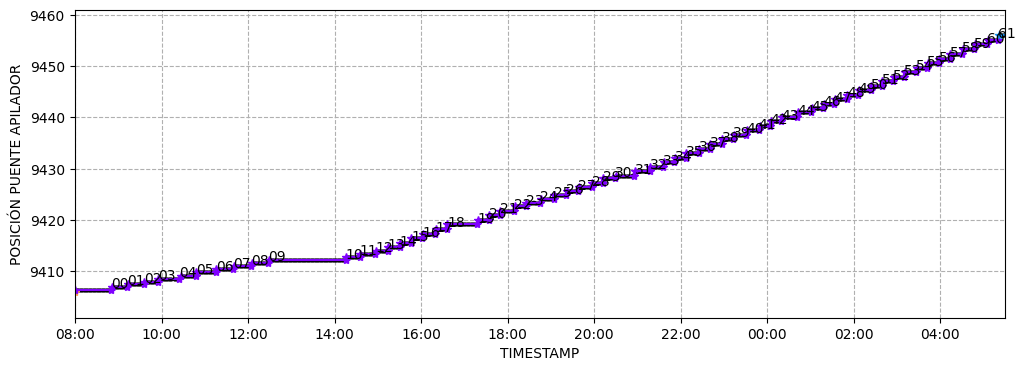

In [0]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ------------------------------------------------------------------------------
# get stacker steps figure
plt.figure(figsize=(12, 4), dpi=100)
ax = plt.gca()

# get stacker gps plot
x = stacker_xy[pads_mask]['x']
plt.plot(x.index, x, '.', color='black', markersize=3)

# get stacker steps plot
tmin, tmax = df_sensors.index.min(), df_sensors.index.max()

for i in df_steps.index:

    # get step timestamps
    tmsp_keys = ['timestamp_start', 'timestamp_end']
    step_tmin, step_tmax = df_steps.loc[i, tmsp_keys]

    # get step plot
    step_pos = df_steps.at[i, 'position']
    step_pad = df_steps.at[i, 'pad_id']

    c = plt.get_cmap('rainbow')((step_pad%5)/5)
    plt.plot([step_tmin, step_tmax], [step_pos, step_pos], color=c, marker='*')

    # get step text
    if (step_tmax > tmin) & (step_tmax < tmax):
        step_txt = '{:02d}'.format(df_steps.at[i, 'step_id'])
        plt.text(step_tmax, step_pos + 0.4, step_txt)

# set plot layout
plt.xlim([tmin, tmax])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('TIMESTAMP')

plt.ylabel('POSICIÓN PUENTE APILADOR')
x = x.loc[tmin:tmax]
if not x.empty:
    plt.ylim([x.min() - 5, x.max() + 5])

plt.grid(linestyle='--')


#### 2.2.3. Stacking Schedule
Una vez obtenida la serie temporal de las franjas de apilado, es posible construir el `schedule` con todos los destinos del puente apilador y así configurar el `ScheduleDivider` que modelará el proceso.

In [0]:
from src.mineflow.blocks.flow import ScheduleStamp

# ------------------------------------------------------------------------------
# get stacker steps schedule
schedule = df_steps.set_index(keys='timestamp_start')
schedule = schedule[['pad_id', 'step_id']]

# get stacker step keys
schedule['step_id'] = schedule['step_id'].astype(str).str.zfill(3)
schedule['pad_id'] = schedule['pad_id'].astype(str).str.zfill(2)
schedule = schedule.agg('_'.join, axis=1)

# get stacker schedule
schedule = schedule.resample('30S').asfreq()
schedule = schedule.fillna(method='ffill').iloc[:-1]
schedule.name = 'step_id'

# get stacker block
stacker = ScheduleStamp(schedule=schedule)
stacker.schedule.head()


timestamp_start
2025-09-01 08:42:30    78_000
2025-09-01 08:43:00    78_000
2025-09-01 08:43:30    78_000
2025-09-01 08:44:00    78_000
2025-09-01 08:44:30    78_000
Freq: 30S, Name: step_id, dtype: object

## 3. Mineral Simulation

### 3.1. Inputs

In [0]:
# ------------------------------------------------------------------------------
# get inputs mineral dataframe
mnl_inputs = list()

for inp in config.get('inputs'):
    
    # get input storage
    input_cntr = inp['storage']['container']
    input_path = inp['storage']['path']
    
    # get input dataframe
    input_path = os.path.join(input_cntr, input_path)
    mnl = pd.read_pickle(input_path)
    mnl_inputs.append(mnl)
    

### 3.2. Simulation

In [0]:
from src.mineflow.blocks.flow import Merge

# ------------------------------------------------------------------------------
# get mineral inputs
mnl = Merge().transform(mnl_inputs)

# simulate stacking pipeline
for belt in stacker_belts:
    mnl = belt.transform(mnl)

# simulate stacker stamp
mnl_outputs = stacker.transform(mnl)


## 4. Datamart Report

En los siguientes bloques de código, las descargas CAEX contenidas en `mnl_outputs` son procesadas para obtener sus franjas de destino y así compilar sus respectivos registros mineralógicos a ingresar en la tabla `descargas_franjas_modulos_propiedades_mineralogicas`.

### 4.1. Stacking Steps Dumps

Para que una descarga CAEX sea agregada al registro histórico de los módulos de lixiviación, esta debe presentar un tracking de toneladas superior a 95%. No obstante, en caso de que el `dump_timestamp` de la descarga se encuentre dentro de la ventana de tiempo determinada por el parámetro `bypass`, esta ingresa directo al reporte, independiente de su tracking.

Notar que una descarga CAEX puede resultar en más de un registro en el reporte, pues se ingresa un registro por franja de destino. La columna `toneladas_camion_franja` indica la cantidad de toneladas que fueron apiladas en cada franja de destino.

In [0]:
# ------------------------------------------------------------------------------
# get report dumps
report = config.get(('reports', 'steps_dumps'))
report_dumps = list()

# get report bypass timestamp
bypass_time = timedelta(minutes=report['bypass'])
bypass_time = df_sensors.index.min() + bypass_time

for dump_id, dump_mnl in mnl_outputs.groupby(by='caex_id'):

    dump_id = int(dump_id)
    if not (dump_id in df_dumps.index):
        continue

    # get dump timestamp & tons
    dump_tmsp = df_dumps.at[dump_id, 'dump_timestamp']
    dump_tons = df_dumps.at[dump_id, 'dump_tons']
    
    # get output tons
    out_tons = dump_mnl['tons'].sum()
    if (out_tons < 0.95*dump_tons) & (dump_tmsp > bypass_time):
        continue
        
    # get dump steps
    for step_id, step_mnl in dump_mnl.groupby(by='step_id'):

        # get dump data
        mnl = df_dumps.loc[dump_id].copy()

        # get dump step keys
        pad_id, step_id = [int(x) for x in step_id.split('_')]
        mnl['step_id'] = step_id
        mnl['pad_id'] = pad_id
        
        # get dump step tons
        step_ratio = step_mnl['tons'].sum()/out_tons
        mnl['tons'] = step_ratio*dump_tons
        report_dumps.append(mnl)


### 4.2. Stacking Pads Loops

Para ingresar correctamente las descargas CAEX a la tabla `descargas_franjas_modulos_propiedades_mineralogicas` es necesario registrar el `id_ciclo` correspondiente a cada uno de sus módulos de destino, pues esto permite discriminar posteriormente la información mineralógica de cada uno de los ciclos de apilamiento que los módulos han experimentado.

Así, en el siguiente bloque de código se obtienen todos los ciclos de apilado de los módulos involucrados en la simulación.


In [0]:
# ------------------------------------------------------------------------------
# get stacker pads dataset as pyspark dataframe
dataset = config.get(('datasets', 'pads'))
stacker_pads = df_steps['pad_id'].unique()

sp_pads= spark.sql(
    """
    SELECT
        modulos.id_modulo, modulos.id_ciclo, 
        modulos.inicio_apilamiento, modulos.fin_apilamiento
    
    FROM
        hive_metastore.ant_cobre_acc_rpt_mineral_tracking.ciclo_de_vida_modulos_lixiviacion AS modulos
        INNER JOIN (
            SELECT
                id_modulo, MAX(id_ciclo) AS ciclo_actual
            FROM
                hive_metastore.ant_cobre_acc_rpt_mineral_tracking.ciclo_de_vida_modulos_lixiviacion
            WHERE
                id_modulo IN ({stacker_pads})
          GROUP BY id_modulo
            ) AS tmp

        ON modulos.id_modulo = tmp.id_modulo
        AND modulos.id_ciclo = tmp.ciclo_actual
    """.format(
        stacker_pads=', '.join(stacker_pads.astype(str))
        )
    )

# ------------------------------------------------------------------------------
# get dataset as pandas dataframe
df_pads = sp_pads.toPandas()
df_pads = df_pads.rename(**dataset['rename'])

# get dataset dataframe
kwargs = dataset['set_schema']
df_pads = set_schema(df_pads, **kwargs)

kwargs = dict(ignore_index=True)
df_pads = df_pads.sort_values(by='timestamp_start', **kwargs)

df_pads.set_index(keys='pad_id', inplace=True)
df_pads.head()


,loop_id,timestamp_start,timestamp_end
pad_id,,,
78,12,2025-09-01 08:42:30,2025-09-02 11:10:00
79,12,2025-09-02 11:10:30,2025-09-03 07:59:00
80,12,2025-09-03 07:59:30,2025-09-04 05:21:00
81,12,2025-09-04 05:21:30,2025-09-04 23:23:30
82,12,2025-09-04 23:24:00,2025-09-05 08:12:30


En caso de que la tabla `ciclo_de_vida_modulos_lixiviacion` no se encuentre actualizada y, en consecuencia, no presente el apilamiento actual en su registro histórico, a continuación se utiliza la información del apilamiento de las franjas (`df_steps`) para rectificar los ciclos contenidos en la tabla `df_pads`

In [0]:
# ------------------------------------------------------------------------------
# get stacker pads loop
for pad_id in df_pads.index:

    # get pad stacker steps
    pad_steps = df_steps.groupby(by='pad_id').get_group(pad_id)
    
    # get pad stacker loop
    pad_tmsp = df_pads.at[pad_id, 'timestamp_start']
    steps_mask = pad_steps['timestamp_start'].gt(pad_tmsp)

    pad_tmsp = df_pads.at[pad_id, 'timestamp_end']
    steps_mask &= pad_steps['timestamp_end'].lt(pad_tmsp)

    pad_flag = df_pads.loc[pad_id].notna().all()
    if pad_flag and (not steps_mask.any()):
        df_pads.at[pad_id, 'loop_id'] += 1

    # set pad stacker loop timestamps
    df_pads.at[pad_id, 'timestamp_start'] = pad_steps['timestamp_start'].min()
    df_pads.at[pad_id, 'timestamp_end'] = pad_steps['timestamp_end'].max()

df_pads.head()


,loop_id,timestamp_start,timestamp_end
pad_id,,,
78,12,2025-09-01 08:42:30,2025-09-02 11:10:00
79,12,2025-09-02 11:10:30,2025-09-03 07:59:00
80,12,2025-09-03 07:59:30,2025-09-04 05:21:00
81,12,2025-09-04 05:21:30,2025-09-04 23:23:30
82,12,2025-09-04 23:24:00,2025-09-05 09:23:30


### 4.3. Datamart Steps Dumps
Finalmente, una vez obtenida toda la información para complementar las descargas CAEX contenidas en `report_dumps`, en el siguiente bloque de código se compila el DataFrame `df_report` con todos los registros mineralógicos a ingresar a la tabla `descargas_franjas_modulos_propiedades_mineralogicas`.

In [0]:
# ------------------------------------------------------------------------------
# get report dumps dataframe
df_report = pd.DataFrame(report_dumps).reset_index(drop=True)

if df_report.empty:
    dbutils.notebook.exit('')

# get pads & steps data
kwargs = dict(on=['pad_id', 'step_id'])
df_report = df_report.join(df_steps.set_index(kwargs['on']), **kwargs)

kwargs = dict(on='pad_id', lsuffix='_step', rsuffix='_pad')
df_report = df_report.join(df_pads, **kwargs)

# get report dataframe
df_report.drop(columns=grmty_keys, inplace=True)
df_report.drop(**report['drop'], inplace=True)

df_report.rename(**report['rename'], inplace=True)
# df_report.head()
display(df_report)


timestamp_descarga,id_camion,toneladas_descarga,id_tronadura,fase,ugm,cut,cus,co3,no3,acido,szo,rsw,cao,pgl,chl,ser,qz,feo,cal,yes,id_franja,id_modulo,toneladas_camion_franja,posicion_franja,inicio_apilamiento_franja,fin_apilamiento_franja,id_ciclo
2025-09-03T07:59:36Z,C30,295.0,F06_1528_260,FASE 6,10.0,0.244289,0.101158,1.387273,0.10522,11.244106,0.434469,0.0134,4.5391,null,4.1193,23.6249,null,null,null,null,4,80,10.746567721451683,9408.465,2025-09-03T09:55:30Z,2025-09-03T10:24:00Z,12
2025-09-03T07:59:36Z,C30,295.0,F06_1528_260,FASE 6,10.0,0.244289,0.101158,1.387273,0.10522,11.244106,0.434469,0.0134,4.5391,null,4.1193,23.6249,null,null,null,null,5,80,73.06176999883733,9409.0715,2025-09-03T10:27:00Z,2025-09-03T10:47:30Z,12
2025-09-03T07:59:36Z,C30,295.0,F06_1528_260,FASE 6,10.0,0.244289,0.101158,1.387273,0.10522,11.244106,0.434469,0.0134,4.5391,null,4.1193,23.6249,null,null,null,null,11,80,127.38332455942188,9412.743255000001,2025-09-03T14:16:00Z,2025-09-03T14:35:00Z,12
2025-09-03T07:59:36Z,C30,295.0,F06_1528_260,FASE 6,10.0,0.244289,0.101158,1.387273,0.10522,11.244106,0.434469,0.0134,4.5391,null,4.1193,23.6249,null,null,null,null,15,80,83.80833772028903,9415.48375,2025-09-03T15:30:30Z,2025-09-03T15:46:00Z,12
2025-09-03T08:04:01Z,C104,295.0,F05_1368_190,FASE 5,40.0,0.231954,0.161369,0.335726,0.1,3.749751,0.624971,0.7047,4.9819,null,6.5186,19.7973,null,null,null,null,4,80,43.20243321940408,9408.465,2025-09-03T09:55:30Z,2025-09-03T10:24:00Z,12
2025-09-03T08:04:01Z,C104,295.0,F05_1368_190,FASE 5,40.0,0.231954,0.161369,0.335726,0.1,3.749751,0.624971,0.7047,4.9819,null,6.5186,19.7973,null,null,null,null,5,80,40.605904500884975,9409.0715,2025-09-03T10:27:00Z,2025-09-03T10:47:30Z,12
2025-09-03T08:04:01Z,C104,295.0,F05_1368_190,FASE 5,40.0,0.231954,0.161369,0.335726,0.1,3.749751,0.624971,0.7047,4.9819,null,6.5186,19.7973,null,null,null,null,11,80,50.96346249107643,9412.743255000001,2025-09-03T14:16:00Z,2025-09-03T14:35:00Z,12
2025-09-03T08:04:01Z,C104,295.0,F05_1368_190,FASE 5,40.0,0.231954,0.161369,0.335726,0.1,3.749751,0.624971,0.7047,4.9819,null,6.5186,19.7973,null,null,null,null,12,80,76.41986206834554,9413.32625,2025-09-03T14:35:30Z,2025-09-03T14:56:00Z,12
2025-09-03T08:04:01Z,C104,295.0,F05_1368_190,FASE 5,40.0,0.231954,0.161369,0.335726,0.1,3.749751,0.624971,0.7047,4.9819,null,6.5186,19.7973,null,null,null,null,14,80,32.7550373873346,9414.63975,2025-09-03T15:14:30Z,2025-09-03T15:30:00Z,12
2025-09-03T08:04:01Z,C104,295.0,F05_1368_190,FASE 5,40.0,0.231954,0.161369,0.335726,0.1,3.749751,0.624971,0.7047,4.9819,null,6.5186,19.7973,null,null,null,null,15,80,51.05330033295446,9415.48375,2025-09-03T15:30:30Z,2025-09-03T15:46:00Z,12


In [0]:
from src.dbutils.pyspark import infer_pandas_schema

# ------------------------------------------------------------------------------
# get report as pyspark dataframe
sp_report = spark.createDataFrame(df_report, infer_pandas_schema(df_report))
sp_report.createOrReplaceTempView("reporte")

# get datamart & report columns
datamart_columns = ', '.join('descargas_franjas.' + df_report.columns)
report_columns = ', '.join('reporte.' + df_report.columns)

# update datamart
debug_flag = int(dbutils.widgets.get("debug_flag"))
if not debug_flag:
    
    sp_datamart = spark.sql(
        """
        MERGE INTO
            ant_cobre_dmt_mineral_tracking.descargas_franjas_modulos_propiedades_mineralogicas AS descargas_franjas

        USING reporte
            ON descargas_franjas.timestamp_descarga = reporte.timestamp_descarga
            AND descargas_franjas.id_camion = reporte.id_camion

            WHEN NOT MATCHED THEN
                INSERT ( {datamart_columns} )
                VALUES ( {reporte_columns} )
        """.format(
            datamart_columns=datamart_columns,
            reporte_columns=report_columns
            )
        )


##5. Trazabilidad tonelaje

- Aquí se almacenan los ultimos logs de tonelajes para monitorear que el producto final del MT este asignando adecuadamente los tonelajes en cada uno de sus procesos

In [0]:
# get forecast timestamps
forecast_tmsp = dbutils.widgets.get("fecha_fin_apilado")
inicio_apilado_tmsp = dbutils.widgets.get("fecha_inicio_apilado")

forecast_tmsp = datetime.strptime(forecast_tmsp, '%Y%m%d%H%M')
inicio_apilado_tmsp = datetime.strptime(inicio_apilado_tmsp, '%Y%m%d%H%M')


In [0]:
tons_logs_path = '/dbfs/mnt/provisioning/dmt/ant/mineral_tracking/mineral_tracking/stg/dataset_tons_logs/dataset_tons_logs_v2.pkl'
df_resumen = pd.read_pickle(tons_logs_path)

tons_stacking = df_report[
    (df_report['inicio_apilamiento_franja'] >= inicio_apilado_tmsp) &
    (df_report['inicio_apilamiento_franja'] <= forecast_tmsp)
]['toneladas_camion_franja'].sum()

df_resumen['tons_stacking'] = tons_stacking

df_resumen.to_pickle(tons_logs_path)

df_resumen

,modulo,inicio_apilado,fin_apilado,tons_dataset,tons_classification,tons_primary,tons_secondary,tons_tertiary,tons_agglomeration,tons_stacking
0,80,2025-09-03 07:59:00,2025-09-04 05:30:00,96465.0,0.0,0.0,73894.441822,13076.102472,72794.59216,66080.0


In [0]:
# En porcentaje respecto a tons_dataset
# columnas = [
#     'tons_dataset',
#     'tons_classification',
#     'tons_primary',
#     'tons_secondary',
#     'tons_agglomeration',
#     'tons_stacking',
# ]

columnas = [col for col in df_resumen.columns if col not in ['modulo', 'inicio_apilado', 'fin_apilado']]

# Convertir a porcentaje con respecto a tons_dataset
df_resumen[columnas] = df_resumen[columnas].div(df_resumen['tons_dataset'], axis=0) * 100
df_resumen

,modulo,inicio_apilado,fin_apilado,tons_dataset,tons_classification,tons_primary,tons_secondary,tons_tertiary,tons_agglomeration,tons_stacking
0,80,2025-09-03 07:59:00,2025-09-04 05:30:00,100.0,0.0,0.0,76.602334,13.555282,75.46218,68.501529


In [0]:
# from pyspark.sql.utils import AnalysisException

# # Crear columna de control a partir de 'fin_apilado'
# df_resumen["timestamp_iteracion_mt"] = pd.to_datetime(df_resumen["fin_apilado"])

# # Intentar obtener la última fecha de la tabla (si existe)
# try:
#     ultima_fecha = spark.sql("""
#         SELECT MAX(timestamp_iteracion_mt) as max_ts 
#         FROM ant_cobre_dmt_mineral_tracking.monitoreo_trazabilidad_tonelajes_logs
#     """).collect()[0]["max_ts"]
# except AnalysisException:
#     # La tabla no existe aún
#     ultima_fecha = None

# # Filtrar si es necesario
# if ultima_fecha is not None:
#     df_resumen_nuevo = df_resumen[df_resumen["timestamp_iteracion_mt"] > ultima_fecha]
# else:
#     df_resumen_nuevo = df_resumen  # Primera escritura: guarda todo

# # Convertir a Spark y particionar por fecha
# sp_resumen = spark.createDataFrame(df_resumen_nuevo).withColumn(
#     "timestamp_iteracion_mt_date",
#     spf.to_date("timestamp_iteracion_mt")
# )

# # Guardar en Delta Table
# (sp_resumen.write
#  .format("delta")
#  .mode("append")
#  .partitionBy("timestamp_iteracion_mt_date")
#  .saveAsTable("ant_cobre_dmt_mineral_tracking.monitoreo_trazabilidad_tonelajes_logs"))


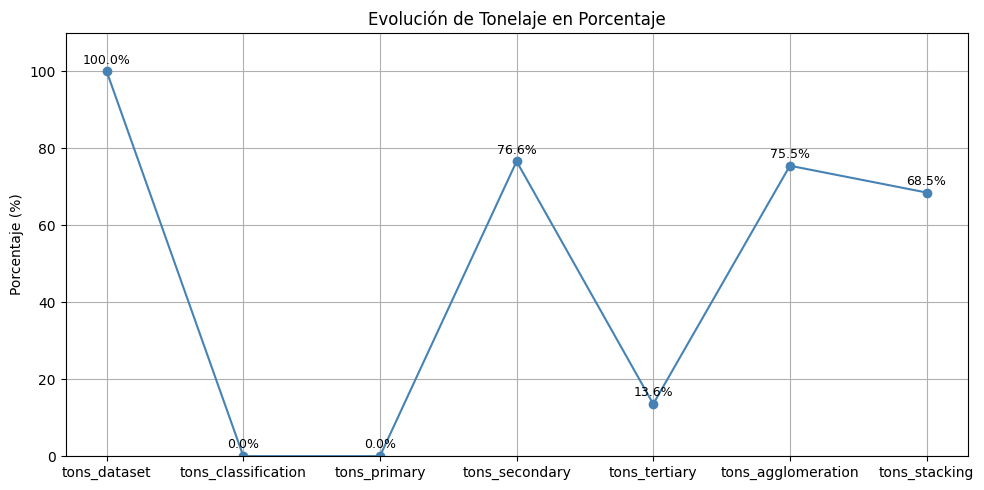

In [0]:
import matplotlib.pyplot as plt

etapas = columnas

# Extraer los valores en porcentaje para esa fila
valores = df_resumen.loc[0, etapas].values

plt.figure(figsize=(10, 5))
plt.plot(etapas, valores, marker='o', linestyle='-', color='steelblue')

plt.title('Evolución de Tonelaje en Porcentaje')
plt.ylabel('Porcentaje (%)')
plt.ylim(0, 110)
plt.grid(True)

# Opcional: añadir etiquetas de valor sobre cada punto
for i, valor in enumerate(valores):
    plt.text(etapas[i], valor + 2, f'{valor:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Revisión sensores

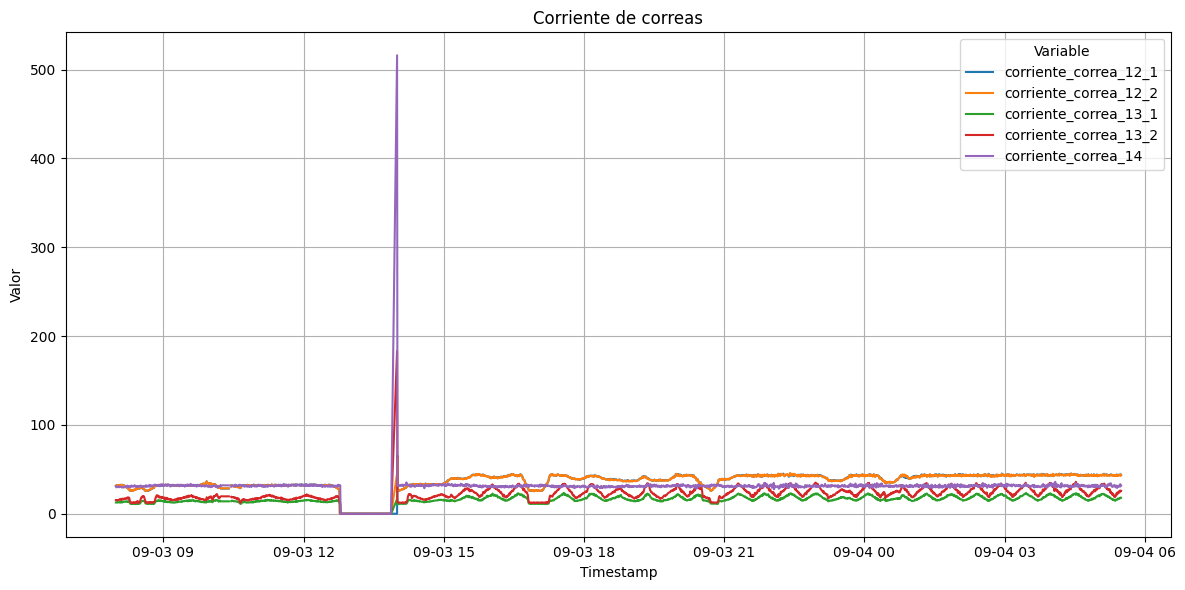

In [0]:
# Lista de variables a graficar
variables = [
    'corriente_correa_12_1', 'corriente_correa_12_2', 'corriente_correa_13_1', 'corriente_correa_13_2', 'corriente_correa_14'
]

plt.figure(figsize=(12, 6))

for var in variables:
    plt.plot(df_sensors.index, df_sensors[var], label=var)

plt.title('Corriente de correas')
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.legend(title='Variable')
plt.grid(True)

plt.tight_layout()
plt.show()


## 7. Envío a Reporte

In [0]:
import requests
import json

df_resumen["inicio_apilado"] = df_resumen["inicio_apilado"].astype(str)
df_resumen["fin_apilado"] = df_resumen["fin_apilado"].astype(str)

# Parámetros fijos o externos
faena = "ANT"
iniciativa = "Monitoreo MT"
nombre_proceso = "Trazabilidad tonelaje"
subproceso = "Job"
estado_actual = "Exito"
responsable = "Samuel Molina"
fase_proceso = "Inicio"
plataforma = "Python Script"

url = "https://prod-04.eastus2.logic.azure.com:443/workflows/c8468783225d4852866d225dd6887d36/triggers/manual/paths/invoke?api-version=2016-10-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=6alkYKdK1t9rSFwX7jpNb-IrzrxyjBVEw2Ua7FOwXak"

headers = {
    "Content-Type": "application/json"
}

# Enviar una petición por cada fila
for _, row in df_resumen.iterrows():
    detalle = {
        "modulo": row["modulo"],
        "inicio_apilado": row["inicio_apilado"],
        "fin_apilado": row["fin_apilado"],
        "tons_dataset": row["tons_dataset"],
        "tons_classification": row["tons_classification"],
        "tons_primary": row["tons_primary"],
        "tons_secondary": row["tons_secondary"],
        "tons_agglomeration": row["tons_agglomeration"],
        "tons_stacking": row["tons_stacking"]
    }

    data = {
        "faena": faena,
        "iniciativa": iniciativa,
        "nombre_proceso": nombre_proceso,
        "subproceso": subproceso,
        "estado_actual": estado_actual,
        "responsable": responsable,
        "fase_proceso": fase_proceso,
        "plataforma": plataforma,
        "Detalle": str(detalle)
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    print("Código de respuesta:", response.status_code)
    print("Respuesta del servidor:", response.text)


Código de respuesta: 202
Respuesta del servidor: 


In [0]:
import requests
import json

df_resumen["inicio_apilado"] = df_resumen["inicio_apilado"].astype(str)
df_resumen["fin_apilado"] = df_resumen["fin_apilado"].astype(str)

# Parámetros fijos o externos
faena = "ANT"
iniciativa = "Monitoreo MT"
nombre_proceso = "Trazabilidad tonelaje"
subproceso = "Job"
estado_actual = "Exito"
responsable = "Samuel Molina"
fase_proceso = "Finalizado"
plataforma = "Python Script"

url = "https://prod-04.eastus2.logic.azure.com:443/workflows/c8468783225d4852866d225dd6887d36/triggers/manual/paths/invoke?api-version=2016-10-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=6alkYKdK1t9rSFwX7jpNb-IrzrxyjBVEw2Ua7FOwXak"

headers = {
    "Content-Type": "application/json"
}

# Enviar una petición por cada fila
for _, row in df_resumen.iterrows():
    detalle = {
        "modulo": row["modulo"],
        "inicio_apilado": row["inicio_apilado"],
        "fin_apilado": row["fin_apilado"],
        "tons_dataset": row["tons_dataset"],
        "tons_classification": row["tons_classification"],
        "tons_primary": row["tons_primary"],
        "tons_secondary": row["tons_secondary"],
        "tons_agglomeration": row["tons_agglomeration"],
        "tons_stacking": row["tons_stacking"]
    }

    data = {
        "faena": faena,
        "iniciativa": iniciativa,
        "nombre_proceso": nombre_proceso,
        "subproceso": subproceso,
        "estado_actual": estado_actual,
        "responsable": responsable,
        "fase_proceso": fase_proceso,
        "plataforma": plataforma,
        "Detalle": str(detalle)
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    print("Código de respuesta:", response.status_code)
    print("Respuesta del servidor:", response.text)


Código de respuesta: 202
Respuesta del servidor: 
